# Probabilistic Multiple Cracking Model of Brittle-Matrix Composite: One-by-One Crack Tracing Algorithm
published in
[**Applied Mathematical Modelling (2020): doi: 10.1016/j.apm.2020.10.041**](https://doi.org/10.1016/j.apm.2020.10.041)
by 
Chudoba, R., Li, Y., Rypl, R., Spartali, H. and Vořechovský, M., 

 - **Investigate** the effect of model parameters on the stress-strain response by changing their values. 
 - **Inspect** the cracking history using the crack slider.
 - **Visit** an annotated source code of the implementation [here](../notebooks/annotated_fragmentation.ipynb)

In [1]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [1]:
%matplotlib notebook
import numpy as np
from scipy.optimize import newton
import matplotlib.pylab as plt

In [2]:
Em=25e3  # [MPa] matrix modulus
Ef=180e3  # [MPa] fiber modulus
vf=0.01  # [-] reinforcement ratio
T=12.  # [N/mm^3] bond intensity
sig_cu=10.0 # [MPa] composite strength
sig_mu=3.0 # [MPa] matrix strength
m=10000 # Weibull shape modulus

In [3]:
## Crack bridge with constant bond
def get_sig_m(z, sig_c):  # matrix stress (*\label{sig_m}*)
    sig_m = np.minimum(z * T * vf / (1 - vf), Em * sig_c / (vf * Ef + (1 - vf) * Em))
    return sig_m

def get_eps_f(z, sig_c):  # reinforcement strain (*\label{sig_f}*)
    sig_m = get_sig_m(z, sig_c)
    eps_f = (sig_c - sig_m * (1 - vf)) / vf / Ef
    return eps_f

In [4]:
## Specimen discretization
def get_z_x(x, XK):  # distance to the closest crack (*\label{get_z_x}*)
    z_grid = np.abs(x[:, np.newaxis] - np.array(XK)[np.newaxis, :])
    return np.amin(z_grid, axis=1)

import warnings # (*\label{error1}*)
warnings.filterwarnings("error", category=RuntimeWarning) # (*\label{error2}*)	
def get_sig_c_z(sig_mu, z, sig_c_pre): 
    # crack initiating load at a material element
    fun = lambda sig_c: sig_mu - get_sig_m(z, sig_c)
    try:  # search for the local crack load level
        return newton(fun, sig_c_pre)
    except (RuntimeWarning, RuntimeError):
        # solution not found (shielded zone) return the ultimate composite strength
        return sig_cu

def get_sig_c_K(z_x, x, sig_c_pre, sig_mu_x):
    # crack initiating loads over the whole specimen
    get_sig_c_x = np.vectorize(get_sig_c_z)
    sig_c_x = get_sig_c_x(sig_mu_x, z_x, sig_c_pre) 
    y_idx = np.argmin(sig_c_x)
    return sig_c_x[y_idx], x[y_idx]

In [5]:
## Crack tracing algorithm
n_x=5000
L_x=500
def get_cracking_history(update_progress=None):
    x = np.linspace(0, L_x, n_x)  # specimen discretization (*\label{discrete}*)
    sig_mu_x = sig_mu * np.random.weibull(m, size=n_x) # matrix strength (*\label{m_strength}*)

    Ec = Em * (1-vf) + Ef*vf # [MPa] mixture rule

    XK = [] # recording the crack postions
    sig_c_K = [0.] # recording the crack initating loads
    eps_c_K = [0.] # recording the composite strains
    CS = [L_x, L_x/2] # crack spacing
    sig_m_x_K = [np.zeros_like(x)] # stress profiles for crack states

    idx_0 = np.argmin(sig_mu_x)
    XK.append(x[idx_0])  # position of the first crack
    sig_c_0 = sig_mu_x[idx_0] * Ec / Em
    sig_c_K.append(sig_c_0)
    eps_c_K.append(sig_mu_x[idx_0] / Em)
    
    while True:
        z_x = get_z_x(x, XK) # distances to the nearest crack
        sig_m_x_K.append(get_sig_m(z_x, sig_c_K[-1])) # matrix stress
        sig_c_k, y_i = get_sig_c_K(z_x, x, sig_c_K[-1], sig_mu_x) # identify next crack
        if sig_c_k == sig_cu: # (*\label{no_crack}*)
            break
        if update_progress: # callback to user interface
            update_progress(sig_c_k)
        XK.append(y_i) # record crack position
        sig_c_K.append(sig_c_k) # corresponding composite stress
        eps_c_K.append( # composite strain - integrate the strain field
        np.trapz(get_eps_f(get_z_x(x, XK), sig_c_k), x) / np.amax(x)) # (*\label{imple_avg_strain}*)
        XK_arr = np.hstack([[0], np.sort(np.array(XK)), [L_x]])
        CS.append(np.average(XK_arr[1:]-XK_arr[:-1])) # crack spacing
    
    sig_c_K.append(sig_cu) # the ultimate state
    eps_c_K.append(np.trapz(get_eps_f(get_z_x(x, XK), sig_cu), x) / np.amax(x))
    CS.append(CS[-1])
    if update_progress:
        update_progress(sig_c_k)
    return np.array(sig_c_K), np.array(eps_c_K), sig_mu_x, x, np.array(CS), np.array(sig_m_x_K)

<IPython.core.display.Javascript object>


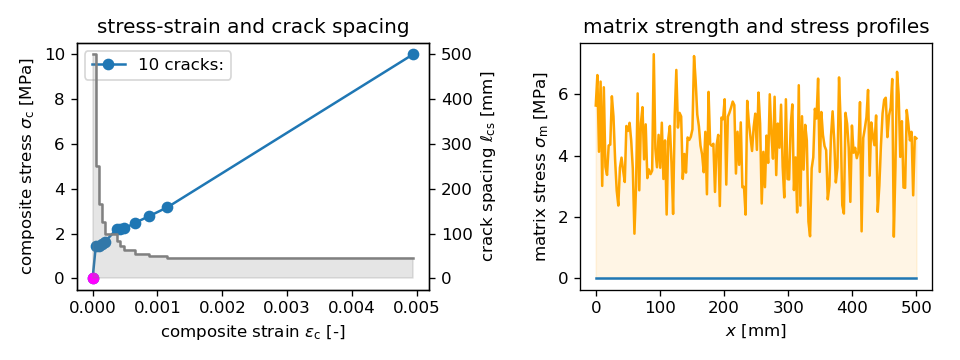

In [6]:
## Interactive application
import ipywidgets as ipw
n_steps = 20
margs_sliders = {
    name : ipw.FloatSlider(description=desc, value=val, 
                            min=minval, max=maxval, step=(maxval-minval) / n_steps,
                           continuous_update=False)
    for name, desc, val, minval, maxval in [
        ('Em', r'\(E_\mathrm{m}\;\)[MPa]', 28e3, 1e3, 50e3),
        ('Ef', r'\(E_\mathrm{f}\;\)[MPa]', 180e3, 1e3, 250e3),
        ('vf', r'\(V_\mathrm{f}\;\)[-]', 0.01, 0.00001, 0.4),
        ('T', r'\(T\;\)[N/mm$^3$]', 8, 0.0001, 20),
        ('sig_cu', r'\(\sigma_\mathrm{cu}\;\)[MPa]', 10, 3, 100),
        ('sig_mu', r'\(\sigma_\mathrm{mu}\;\)[MPa]',5.0, 1, 10),
        ('m', r'\(m\;\)[-]',4,0.8,100),
        ('L_x', r'\(L\;\)[mm]',500,200,2000)
    ]
}
pmcm_args = ['sig_cu','sig_mu', 'm','L_x','n_x']
cb_args = ['Em','Ef','vf','T']

margs_sliders['n_x'] = ipw.IntSlider(description='$n_\mathrm{points}$', value=200,
                             min=20, max=1000, step=10, continuous_update=False)
crack_slider = ipw.IntSlider(description='crack', value=0, min=0, max=1, step=1)
progress = ipw.FloatProgress(min=0, max=1) # instantiate the bar

fig, (ax, ax_sig_x) = plt.subplots(1,2,figsize=(8,3),tight_layout=True)
ax_cs = ax.twinx()

def update_progress(sig):
    progress.value = sig

def init():
    for key, sl in margs_sliders.items():
        globals()[key] = sl.value
    sig_c_K, eps_c_K, sig_mu_x, x, CS, sig_m_x_K = get_cracking_history(update_progress) # (*\label{calc_curve}*)
    progress.max = margs_sliders['sig_cu'].value
    ax.plot(eps_c_K, sig_c_K, marker='o') # (*\label{show_curve1}*)
    ax_sig_x.plot(x, sig_mu_x, color='red')

current_sig_m_x_K = []
current_x = []
def reset_crack_slider(x, sig_m_x_K):
    global current_sig_m_x_K, current_x, sig_m_line, sig_eps_marker
    current_sig_m_x_K = sig_m_x_K
    current_x = x
    n_cracks = len(sig_m_x_K)
    crack_slider.max = n_cracks-1
    crack_slider.value = 0
    sig_m_line, = ax_sig_x.plot(x, sig_m_x_K[0])
    sig_eps_marker, = ax.plot([0],[0],color='magenta',marker='o')
    
def update_crack_slider(crack):
    global sig_m_line, sig_eps_marker
    global sig_c_K, eps_c_K
    if len(current_sig_m_x_K) > 0:
        sig_m_line.set_ydata(current_sig_m_x_K[crack])
    sig_eps_marker.set_data(eps_c_K[crack],sig_c_K[crack])
        
def update(**mparams):
    global sig_c_K, eps_c_K
    for key, val in mparams.items():
        globals()[key] = val
    ax.clear()
    ax_cs.clear()
    ax_sig_x.clear()
    ax.set_title('stress-strain and crack spacing')
    ax_sig_x.set_title('matrix strength and stress profiles')
    sig_c_K, eps_c_K, sig_mu_x, x, CS, sig_m_x_K = get_cracking_history(update_progress) # (*\label{calc_curve}*)
    n_c = len(eps_c_K) - 2 # numer of cracks
    ax.plot(eps_c_K, sig_c_K, marker='o', label='%d cracks:' % n_c) # (*\label{show_curve1}*)
    ax.set_xlabel(r'composite strain $\varepsilon_\mathrm{c}$ [-]'); 
    ax.set_ylabel(r'composite stress $\sigma_\mathrm{c}$ [MPa]')
    ax_sig_x.plot(x, sig_mu_x, color='orange')
    ax_sig_x.fill_between(x, sig_mu_x, 0, color='orange',alpha=0.1)
    ax_sig_x.set_xlabel(r'$x$ [mm]'); ax_sig_x.set_ylabel(r'matrix stress $\sigma_\mathrm{m}$ [MPa]')
    ax.legend()
    eps_c_KK = np.array([eps_c_K[:-1], eps_c_K[1:]]).T.flatten()
    CS_KK = np.array([CS[:-1],CS[:-1]]).T.flatten()
    ax_cs.plot(eps_c_KK, CS_KK, color='gray')
    ax_cs.fill_between(eps_c_KK, CS_KK, color='gray', alpha=0.2)
    ax_cs.set_ylabel(r'crack spacing $\ell_\mathrm{cs}$ [mm]');
    reset_crack_slider(x, sig_m_x_K)

def slider_layout():
    hbox_pr = ipw.HBox([progress])
    hbox = ipw.HBox([crack_slider])
    pmcm_layout = ipw.Layout(grid_template_columns='1fr')
    pmcm_list = [ipw.Label('Crack tracing parameters')] + \
        [margs_sliders[arg] for arg in pmcm_args]
    pmcm_col = ipw.GridBox(pmcm_list, layout=pmcm_layout)
    cb_layout = ipw.Layout(grid_template_columns='1fr')
    cb_list = [ipw.Label('Crack bridge parameters')] + \
        [margs_sliders[arg] for arg in cb_args]
    cb_col = ipw.GridBox(cb_list, layout=cb_layout)
    alg_params = ipw.HBox([pmcm_col, cb_col])
    box = ipw.VBox([hbox_pr, hbox, alg_params])
    display(box)
    
init()
slider_layout()
ipw.interactive_output(update_crack_slider, {'crack':crack_slider})
ipw.interactive_output(update, margs_sliders);

# Model parameters

| Symbol | Unit | Description
| :-: | :-: | :- |
| $E_\mathrm{m}$ | MPa | Elastic modulus of matrix |
| $E_\mathrm{f}$ | MPa | Elastic modulus of reinforcement |
| $V_\mathrm{f}$ |- | reinforcement ratio |
| $T$ | N/mm$^3$ | Bond intensity | 
| $\sigma_\mathrm{cu}$ | MPa | Composite strength |
| $\sigma_\mathrm{mu}$ | MPa | Scale parameter of matrix strength distribution |
| $m$ | - | Weibull modulus |
| $L$ | mm | Specimen length |
| $n_\mathrm{points}$ | - | Number of discretization points |